# Traffic Sign Classifier Project

As the world moves more and more towards automatic cars, there is an increasing importance for a machine capable of classifying various traffic signs. Using image data from tens of thousands of 32 x 32 traffic signs, this project involves the use of building and training a neural network capable of accurately predicting given traffic signs.

In [2]:
#Import neccessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile38 as zipfile
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
sns.set_theme()
print("Imported modules!")

Imported modules!


# Step 1 - Preparing Labels

Image labels from the dataset are encoded into numbers due to the need for neural networks to have numerical data. The csv file labels.csv holds info on which numbers/IDs match with the sign name. This info is needed for making predictions on new data.

In [3]:
#Get all labels for the dataset and create a dictionary to map IDs to word labels

label_csv = pd.read_csv('labels.csv')
class_id = np.array(label_csv['ClassId'])
name = np.array(label_csv['Name'])
id2name = {ID: NAME for ID, NAME in zip(class_id, name)}
print(id2name)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vechiles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vechiles', 16: 'Vechiles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

# Step 2 - Retrieving Data from Zip File

The data on traffic signs and their labels is located in a zipfile that requires manual retrieving. Each individual unique ID has its own folder in the zip file with all the images corresponding to that ID. 

In [12]:
#Get vectorized images and their labels into two lists

all_images = []
image_labels = []
with zipfile.ZipFile("trafficData.zip", "r") as zip_data:
    content_list = zip_data.namelist()
    content_list = [l for l in content_list if '.jpg' in l]
    
    for name_file in content_list: #Go through every file containing an image
        
        #Get vectorized image array and append into all_images
        
        img_bytes = zip_data.open(name_file)         
        img_data = Image.open(img_bytes)            
        image_as_array = np.array(img_data, np.uint8) 
        image_as_array = image_as_array / 255.0   #Normalize data between 0 and 1
        all_images.append(image_as_array)
        
        #Get the label from the file name and append to image_labels

        label = int(name_file.split('/')[1])
        image_labels.append(label)

all_images, image_labels = np.array(all_images), np.array(image_labels)

#Print out shape of list

print(all_images.shape)
print(image_labels.shape)

(73139, 32, 32, 3)
(73139,)


# Step 3 - Data Visualization

Before training a neural network on data, it is important to gain a solid understanding of the data you're dealing with. One way to understand your data is through data visualization. 

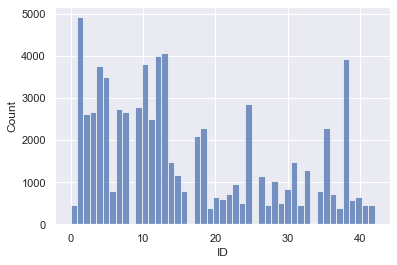

In [52]:
#Create visualization of every traffic image and their amount of data

sns.histplot(x=image_labels)
sns.set_theme()
plt.xlabel('ID')
plt.show()

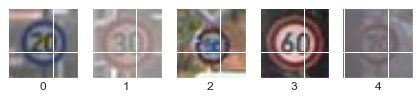

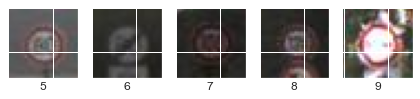

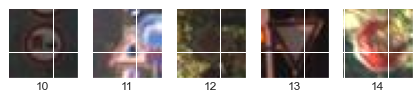

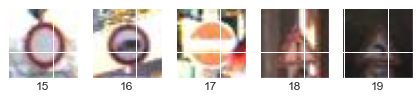

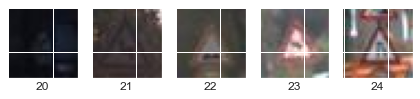

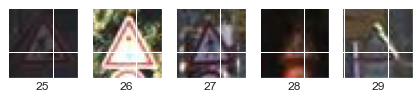

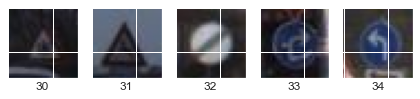

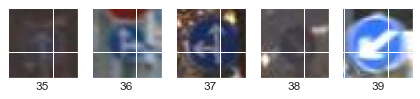

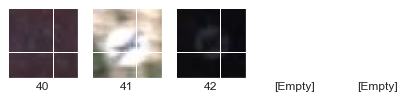

In [43]:
#Make graph consisting of all pictures from all labels, to better visualize the dataset

current_label = 0
rows = 9
cols = 5

for row in range(rows):
    fig, ax = plt.subplots(1, cols)
    for col in range(cols):
        
        #Since there are 43 labels, the full image matrix will be 9 x 5 with 2 empty boxes
        
        if current_label in class_id:
            
            #If the label exists: Display the first image with the label
            
            the_img = [all_images[i] for i in range(len(all_images)) if image_labels[i] == current_label][0]
            ax[col].imshow(the_img)
            ax[col].set_xlabel(current_label)
            
        else:
            
            #If the label does not exist: Display an empty white image
            
            the_img = np.ones((32, 32, 3))
            ax[col].imshow(the_img)
            ax[col].set_xlabel("[Empty]")
        
        #Remove x and y axis for better visualization
        
        ax[col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        
        current_label += 1
            
    fig.tight_layout()
    plt.show()

# Step 4 - Create Neural Network

Depending on the type of problem being faced, different types of neural networks are required. This problem involves traffic sign classification, which is an image classification problem. Therefore, Convolutional Neural Networks are needed. 

In [13]:
#Function to create Convolutional Model for traffic sign prediction

def create_model(classes):
    
    '''
    The model will consist of 2 dimensional Convolutional Networks(as CNNs are designed for image classification)
    Since the input image is rather simple at 32 x 32, there will only be 2 32 filters and 2 64 filters with a 3x3 kernel
    After the Convolutional Layers, the result will be flattened and ended with a fully connected softmax output layer
    The optimizer will be adam and the loss will be categorical crossentropy, which is standard for CNNs
    '''
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#Create the neural network using the create_model function

model = create_model(len(class_id))
print("Created model!")

Created model!


# Step 5 - Retrieve Training and Testing Data

When training a neural network, or using any other Machine Learning Algorithm, there is a chance of the network overfitting on the input data, meaning the model only learns to match training inputs to their training outputs, rather than learning and understanding the type of data. 

Therefore, data is generally seperated into training and testing, where the training data is trained with the algorithm and the testing data is used afterwards to check the validity of the data. Generally, validation data is also used as a means to not overfit on testing data when tweaking models, but the validation data in this project will involve real life images. 

In [18]:
#The model will use categorical crossentropy as the loss function, so convert image_labels to categorical

image_labels = to_categorical(image_labels)

#Split the data into training and testing for predictions

X_train, X_test, y_train, y_test = train_test_split(all_images, image_labels, test_size=0.25, random_state=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(54854, 32, 32, 3) (18285, 32, 32, 3)
(54854, 43) (18285, 43)


# Step 6 - Training Model

Now that the training and testing data are ready to be inputted into the neural network, it becomes time for the model to be trained through forward and back propagation. For images, Image Data Generators can be used on the training images to generate more unique images and thus get a more accurate model. 

In [21]:
#Create an Image Data Generator to generate more images for the training set in the neural network

datagen = ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)
datagen.fit(X_train) #Fit the datagenerator on X_train to prepare data

#Fit and save the model with 5 epochs and a batch size of 64 

model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=5, validation_data=(X_test, y_test))
model.save('Traffic_CNN')

Epoch 1/5
858/858 [==============================] - 34s 38ms/step - loss: 2.5741 - accuracy: 0.3014 - val_loss: 0.1842 - val_accuracy: 0.9587
Epoch 2/5
858/858 [==============================] - 31s 37ms/step - loss: 0.4688 - accuracy: 0.8587 - val_loss: 0.0634 - val_accuracy: 0.9835
Epoch 3/5
858/858 [==============================] - 32s 38ms/step - loss: 0.2479 - accuracy: 0.9236 - val_loss: 0.0410 - val_accuracy: 0.9887
Epoch 4/5
858/858 [==============================] - 32s 38ms/step - loss: 0.1775 - accuracy: 0.9448 - val_loss: 0.0274 - val_accuracy: 0.9931
Epoch 5/5
858/858 [==============================] - 32s 37ms/step - loss: 0.1363 - accuracy: 0.9580 - val_loss: 0.0182 - val_accuracy: 0.9955
INFO:tensorflow:Assets written to: Traffic_CNN/assets


# Step 7 - Test Model on Real Life Images

The testing accuracy for the neural network is 99.55%, but in order to validate that the neural network will be accurate on real images, real images are needed. The validation data for this project will involve 7 images retrieved from real roads on Google. 

In [45]:
#Load model to make further prediction

model = load_model('Traffic_CNN')

#Function to predict label of image given path to image file

def pred_image(img_file):
    
    #Use PIL to open and resize the image
    
    img = Image.open(img_file)
    img = img.resize((32, 32))
    img_arr = np.array(img)[:, :, :3].reshape(1,32,32,3)
    
    #Use the model and id2name dictionary to predict the label of the image
    
    pred = model.predict(img_arr / 255.0)
    pred_name = id2name[np.argmax(pred)]
    
    return pred_name

print("Completed loading model and pred_image function")

Completed loading model and pred_image function


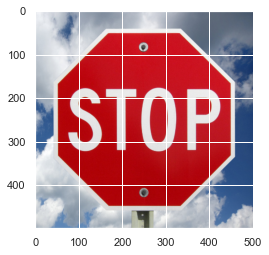

Stop


In [23]:
#FIRST PREDICTION: Stop Sign

path_to_file = 'stopsign.png'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

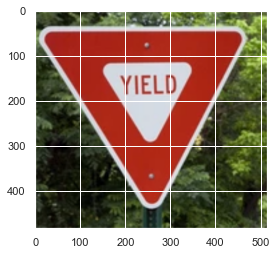

Yield


In [24]:
#SECOND PREDICTION: Yield Sign

path_to_file = 'yieldsign.png'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

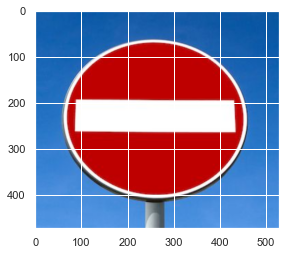

No entry


In [27]:
#THIRD PREDICTION: No Entry Sign

path_to_file = 'donotenter.png'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

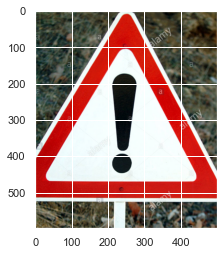

General caution


In [30]:
#FOURTH PREDICTION: Caution Sign

path_to_file = 'caution.png'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

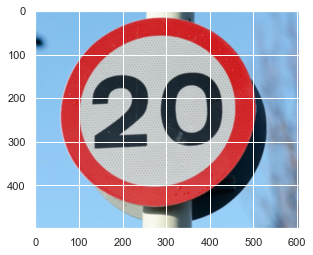

Speed limit (20km/h)


In [34]:
#FIFTH PREDICTION: Speed limit 20 km Sign

path_to_file = 'speedlimit20.jpg'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

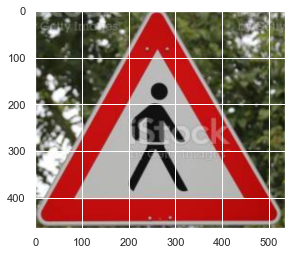

Traffic signals


In [51]:
#SIXTH PREDICTION: Pedestrian Sign 

path_to_file = 'pedestrian.png'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

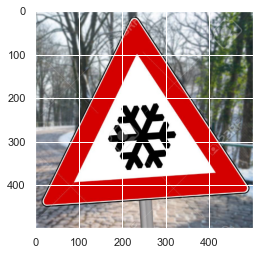

Beware of ice/snow


In [43]:
#SEVENTH PREDICTION: Pedestrian Sign 

path_to_file = 'bewaresnow.jpg'

arr_image = np.array(Image.open(path_to_file))
plt.imshow(arr_image)
plt.show()

print(pred_image(path_to_file))

# Conclusion

Out of the 7 real life images used, the neural network got 6 of them correct. This shows that the model is generally sufficient at classifying signs in real life. 